# Linear Classifier & Model Comparison

## Group Members
- Rishabh TIWARI
- Erfan AMIDI
- Felipe BAGNI
- Federica VINCIGUERRA
- Dan LIONIS

## Overview

In this notebook, we leverage the use of linear models, specifically clustering techniques, on our dataset to establish the grounds for comparing different models. The models evaluated in this notebook are:

- GPT's davinci-002 (referenced as **m0**)
- GPT's davinci-002 after fine-tuning (referenced as **m1**)
- GPT-3.5-turbo-0125 (referenced as **m2**)
- GPT-3.5-turbo-0125 after fine-tuning (referenced as **m3**)
- Google's T5 Small (referenced as **mf1**)
- Google's T5 Small after fine-tuning (referenced as **mf2**)

## Dataset
The dataset used for the fine-tuning and comparison of these models is the "Medical Meadow Medical Flashcards."

This notebook aims to provide a detailed comparison of these models' performance using linear classifiers and clustering methods, highlighting the impact of fine-tuning on their effectiveness.

#1.0 importing Libraries

In this part we import all the required libraries and the codes to ignore the warnings

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import warnings
from datasets import Dataset
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import csv
from sentence_transformers import SentenceTransformer
import random
import json
import openai

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')
warnings.filterwarnings("ignore", category=ConvergenceWarning, module='sklearn')
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore")

# Loading and Exploring the Dataset

## Step 1: Load the Dataset
- Loaded the dataset from a saved arrow file using the `Dataset.from_file` method.

## Step 2: Convert to Pandas DataFrame
- Converted the dataset into a Pandas DataFrame for ease of analysis.

## Step 3: Initial Exploration
- Displayed the total number of documents in the dataset.
- Provided a preview of the first few rows of the DataFrame to understand its structure and content.

### Example Output
- **Number of Documents:** Displayed the count of documents in the dataset.
- **Data Preview:** Showed the first few rows of the DataFrame for initial inspection.

In [ ]:
# Load the dataset from the saved arrow file
dataset = Dataset.from_file('/workspaces/NLP-Polimi-Project/Practice Models/Erfan/Data/train/data-00000-of-00001.arrow')

# Convert to Pandas DataFrame for analysis
df = dataset.to_pandas()

print(f"Dataset contains {len(df)} documents.")
print(df.head())

Dataset contains 33955 documents.
                                               input  \
0  What is the relationship between very low Mg2+...   
1  What leads to genitourinary syndrome of menopa...   
2  What does low REM sleep latency and experienci...   
3  What are some possible causes of low PTH and h...   
4  How does the level of anti-müllerian hormone r...   

                                              output  \
0  Very low Mg2+ levels correspond to low PTH lev...   
1  Low estradiol production leads to genitourinar...   
2  Low REM sleep latency and experiencing halluci...   
3  PTH-independent hypercalcemia, which can be ca...   
4  The level of anti-müllerian hormone is directl...   

                       instruction  
0  Answer this question truthfully  
1  Answer this question truthfully  
2  Answer this question truthfully  
3  Answer this question truthfully  
4  Answer this question truthfully  


# Frequent Terms Analysis in the Output Column

## Step 1: Stop Words Removal
- Downloaded and set up the list of English stop words using NLTK.

## Step 2: Tokenization
- Tokenized the `output` column of the DataFrame to create a list of all words in the output text.
- Converted all tokens to lowercase for uniformity.

## Step 3: Filtering
- Removed stop words from the list of tokens to focus on the most meaningful terms.

## Step 4: Frequency Count
- Counted the occurrences of each term in the filtered token list.
- Identified and listed the 50 most common terms in the `output` column.

## Results
- Displayed the most common terms to provide insights into the frequent topics and terms present in the output text.

In [ ]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Tokenize the 'output' column to find frequent terms
output_text = ' '.join(df['output'].astype(str).tolist())
tokens = output_text.lower().split()

# Remove stop words from the tokens
filtered_tokens = [token for token in tokens if token not in stop_words]

# Count the most frequent terms
common_terms = [term for term, count in Counter(filtered_tokens).most_common(50)]
print(f"Most common terms: {common_terms}")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Most common terms: ['may', 'treatment', 'blood', 'cause', 'symptoms', 'important', 'used', 'condition', 'type', 'typically', 'include', 'lead', 'also', 'risk', 'associated', 'cells', 'including', 'patients', 'caused', 'help', 'disease', 'characterized', 'cell', 'medical', 'common', 'prevent', 'levels', 'involves', 'heart', 'commonly', 'increased', 'infection', 'due', 'however,', 'syndrome', 'healthcare', 'medications', 'immune', 'known', 'increase', 'diagnosis', 'leading', 'one', 'occurs', 'often', 'cancer', 'cases,', 'recommended', 'individuals', 'well']


# Checking Presence of Relevant Medical Terms in the Dataset

## Step 1: Define Relevant Medical Terms
- Identified a list of relevant medical terms to look for in the dataset:
  - `treatment`
  - `symptoms`
  - `patient`
  - `blood`
  - `cause`
  - `condition`
  - `risk`
  - `cells`
  - `patients`
  - `associated`

## Step 2: Check Presence of Relevant Terms
- Checked each term from the list to see if it is present in the `output` column of the dataset.
- Ignored case differences and handled missing values gracefully.

## Results
- Displayed the relevant medical terms that are present in the dataset, providing insights into the medical topics covered by the text.

### Example Output
- **Present Terms:** A list of medical terms found in the dataset's `output` column.

In [ ]:
# Define relevant medical terms you want to look for in the dataset
relevant_terms = ['treatment', 'symptoms', 'patient', 'blood', 'cause', 'condition', 'risk', 'cells', 'patients', 'associated']

# Check presence of relevant terms in the dataset
present_terms = [term for term in relevant_terms if df['output'].str.contains(term, case=False, na=False).any()]
print(f"Present terms: {present_terms}")

Present terms: ['treatment', 'symptoms', 'patient', 'blood', 'cause', 'condition', 'risk', 'cells', 'patients', 'associated']


# Filtering the Dataset for Relevant Medical Terms

## Step 1: Filter the Dataset
- Filtered the dataset to include only the documents where the `output` column contains any of the relevant medical terms identified.

## Step 2: Update Feature and Target Variables
- Updated `X` to be the `input` column of the filtered DataFrame.
- Updated `y` to be the `output` column of the filtered DataFrame.

## Step 3: Ensure Target Variable Consistency
- Modified `y` to ensure it only contains the relevant medical terms.
  - For each entry in `y`, checked for the presence of any relevant term.
  - If a relevant term is found, it is assigned as the value for that entry.
  - If no relevant term is found, the entry is labeled as 'other'.

## Results
- Obtained a filtered dataset focusing on documents containing the relevant medical terms.
- Ensured that the target variable (`y`) is consistent and only contains the relevant terms or 'other'.

In [ ]:
# Filter the dataset to only include these present relevant terms
filtered_df = df[df['output'].str.contains('|'.join(present_terms), case=False, na=False)]

# Update X and y after filtering
X = filtered_df['input']
y = filtered_df['output']

# Ensure that y only contains our relevant terms
y = y.apply(lambda ans: next((term for term in present_terms if term in ans.lower()), 'other'))

# Class Distribution Analysis

## Initial Class Distribution
- Printed the class distribution of the target variable (`y`) before filtering out the 'other' category.
  - This step helps to understand the initial distribution of relevant medical terms in the dataset.

## Final Class Distribution
- Printed the final class distribution of the target variable (`y`) after filtering out the 'other' category.
  - This ensures that the dataset is ready for training, focusing only on the relevant medical terms.

## Insights
- Comparing the class distributions before and after filtering provides insights into the prevalence of each medical term and the impact of filtering on the dataset.

In [ ]:
# Print the class distribution before further filtering
print("Class distribution before filtering 'other':")
print(y.value_counts())

# Check the final class distribution to ensure the dataset is ready for training
print("Final class distribution:")
print(y.value_counts())

Class distribution before filtering 'other':
output
treatment     7085
cause         3437
patient       2459
symptoms      2196
blood         1894
associated    1281
cells         1087
condition      698
risk           627
Name: count, dtype: int64
Final class distribution:
output
treatment     7085
cause         3437
patient       2459
symptoms      2196
blood         1894
associated    1281
cells         1087
condition      698
risk           627
Name: count, dtype: int64


# Text Data Conversion and Clustering Analysis

## Step 1: Convert Text Data to TF-IDF Features
- Transformed the text data (`X`) into TF-IDF features using the `TfidfVectorizer`.
  - **Parameters:**
    - `max_features=5000`: Limited the number of features to 5000.
    - `ngram_range=(1, 2)`: Considered both unigrams and bigrams.
    - `stop_words='english'`: Excluded common English stop words.

## Step 2: K-Means Clustering
- Determined the number of clusters based on the unique classes in the target variable (`y`).
- Applied K-Means clustering to the TF-IDF features.
- Added the cluster labels to the filtered DataFrame.
- Calculated the silhouette score to evaluate the clustering performance.

## Step 3: Silhouette Score
- Printed the silhouette score to assess the quality of the clustering.
  - The silhouette score indicates how similar an object is to its own cluster compared to other clusters.
  - A higher score suggests better-defined clusters.

## Step 4: Elbow Method for Optimal Clusters
- Defined a range for the number of clusters to try (from 2 to 10).
- Calculated the Within-Cluster Sum of Squares (WCSS) for each number of clusters.
- Plotted an elbow plot to determine the optimal number of clusters.
  - The elbow point in the plot indicates the optimal number of clusters, where adding more clusters doesn't significantly improve the WCSS.

## Results
- Displayed the filtered DataFrame with the added cluster labels.
- Provided insights into the clustering performance through the silhouette score and elbow plot.

## Example Outputs
- **Silhouette Score:** A numerical value indicating the clustering quality.
- **Elbow Plot:** A graphical representation to help determine the optimal number of clusters.
- **Filtered DataFrame:** The DataFrame with cluster labels added.


Silhouette score: 0.01


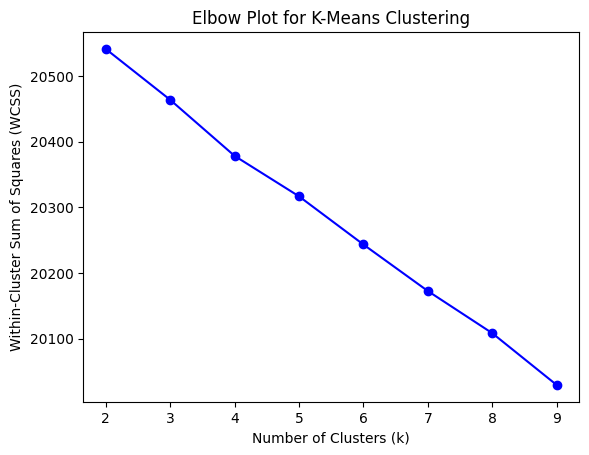

                                                   input  \
3      What are some possible causes of low PTH and h...   
6      What are the possible causes of low glucose an...   
7      What can cause low Glucose and high C-peptide ...   
8      What is the relationship between low Ejection ...   
9            What condition is associated with low DLCO?   
...                                                  ...   
33941  What is "Busulfan Lung", and what type of lung...   
33943  What are the symptoms of dengue fever, and how...   
33946  What is Opsoclonus-Myoclonus Ataxia Syndrome, ...   
33947  What is Opsoclonus-Myoclonus Ataxia Syndrome, ...   
33949  What is the mnemonic "Microtubules Get Constru...   

                                                  output  \
3      PTH-independent hypercalcemia, which can be ca...   
6      Low glucose and high C-peptide levels can be c...   
7      Insulinoma or sulfonylurea drugs can cause low...   
8      Low Ejection fraction is commonl

In [ ]:
# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')
X_tfidf = vectorizer.fit_transform(X)


n_clusters = len(np.unique(y))
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
y_pred = kmeans.fit_predict(X_tfidf)

# Add cluster labels to the DataFrame
filtered_df = filtered_df.copy()
filtered_df['Cluster_no'] = kmeans.labels_

silhouette = silhouette_score(X_tfidf, y_pred)
print(f"Silhouette score: {silhouette:.2f}")


# Define the range of number of clusters to try
k_values = range(2, 10)

wcss_values = []

for k in k_values:

    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_tfidf)
    wcss = kmeans.inertia_
    wcss_values.append(wcss)

# Plot the elbow plot
plt.plot(k_values, wcss_values, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Plot for K-Means Clustering')
plt.show()

print(filtered_df)

# Evaluation and Embedding Calculation

## BLEU Score Calculation
- Defined a function to calculate the BLEU score, which measures the similarity between reference and predicted text sequences.
  - **Tokenization:** Tokenized the reference and predicted sequences.
  - **Smoothing Function:** Applied a smoothing function to handle cases with short sequences and avoid zero scores.
  - **BLEU Score:** Used the `sentence_bleu` function from NLTK to compute the BLEU score.

## Sentence Embeddings
- Generated sentence embeddings for the `output` column using the `SentenceTransformer` model (`all-MiniLM-L6-v2`).
  - Encoded each output sequence into a dense vector representation.
  - Added these embeddings as a new column in the filtered DataFrame.

## Purpose
- **BLEU Score:** Provides a quantitative measure of the accuracy of text predictions, useful for evaluating models in tasks like machine translation and text generation.
- **Sentence Embeddings:** Transform the text data into numerical vectors that capture semantic meaning, enabling further analysis such as clustering, similarity measurement, and other NLP tasks.

## Steps
1. **BLEU Score Calculation:**
   - Tokenized the reference and predicted text sequences.
   - Applied a smoothing function.
   - Calculated the BLEU score to evaluate the similarity.

2. **Sentence Embedding Calculation:**
   - Loaded the `SentenceTransformer` model.
   - Encoded the `output` column into embeddings.
   - Added the embeddings as a new column to the filtered DataFrame.

## Results
- **BLEU Scores:** Quantitative evaluation of text predictions.
- **Embeddings:** Numerical representations of text data for advanced NLP tasks.

### Example Outputs
- **Filtered DataFrame:** The DataFrame with an additional column for sentence embeddings.

In [ ]:
def calculate_bleu(reference, prediction):
    reference_tokens = [nltk.word_tokenize(reference)]
    prediction_tokens = nltk.word_tokenize(prediction)
    # Using smoothing function to avoid zero scores for short sequences
    smoothing_function = SmoothingFunction().method1
    bleu_score = sentence_bleu(reference_tokens, prediction_tokens, smoothing_function=smoothing_function)
    return bleu_score
nltk.download('punkt')

#embeddings
model = SentenceTransformer('all-MiniLM-L6-v2')
filtered_df['embedding'] = model.encode(filtered_df['output'].tolist()).tolist()

[nltk_data] Downloading package punkt to /home/codespace/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Model Comparison and Evaluation

## Overview
In this section, we evaluate various models on a set of randomly selected questions and compare their performance using different metrics such as cosine similarity and BLEU scores.

## Steps Involved

### 1. Setup
- Loaded the necessary API keys and data files including random questions and generated answers from different models.

### 2. Initialization
- Initialized counters and tables to store results for each model.

### 3. Answer Generation
- Defined functions to generate answers using different models:
  - `generate_answer2` for GPT-3.5-turbo-0125.
  - `generate_answer3` for a fine-tuned GPT-3.5-turbo-0125 model.

### 4. Random Question Selection
- Selected a set of random questions from the filtered DataFrame.
- Matched the questions with their corresponding cluster to find similar answers.

### 5. Embedding and Similarity Calculation
- Used the `SentenceTransformer` model to generate embeddings for the responses.
- Calculated cosine similarity between the generated answers and the most similar answers from the top 5 similar answers.
- Also calculated cosine similarity between the generated answers and the actual answer.

### 6. BLEU Score Calculation
- Computed the BLEU scores to measure the quality of the generated answers against the actual answers.

### 7. Result Storage
- Stored the results in tables for each model including:
  - Question, actual answer, generated response, most similar answer, whether the most similar answer matches the actual answer, cosine similarity, and BLEU score.

### 8. Final Metrics Calculation
- Calculated overall metrics for each model:
  - Similarity rate, average cosine similarity, and average BLEU score.

### 9. Data Saving
- Saved the results and comparison metrics into CSV files for further analysis.

## Results
- **Similarity Rate:** The rate at which the most similar answer matches the actual answer.
- **Average Cosine Similarity:** The average cosine similarity between generated responses and the actual answers.
- **Average BLEU Score:** The average BLEU score for the generated responses.

### Example Output
- **Tables:** Detailed results for each model including all computed metrics.
- **CSV Files:** Final metrics and comparison results saved for analysis.

## CSV Files Generated
- `random_rows.csv`: Contains the randomly selected questions.
- `m0_results.csv`: Results for GPT's davinci-002 model.
- `m1_results.csv`: Results for GPT's davinci-002 after fine-tuning.
- `m2_results.csv`: Results for GPT-3.5-turbo-0125.
- `m3_results.csv`: Results for GPT-3.5-turbo-0125 after fine-tuning.
- `mf0_results.csv`: Results for Google's T5 Small.
- `mf1_results.csv`: Results for Google's T5 Small after fine-tuning.
- `final_model_comparison.csv`: Comparison metrics for all models.

In [ ]:
api_key ="#####################################" #ADD YOU API KEY HERE
openai.api_key = api_key

random_rows = pd.read_csv('/workspaces/NLP-Polimi-Project/Practice Models/Erfan/Data/random_questions.csv')
mf0_generated_answers = pd.read_csv('/workspaces/NLP-Polimi-Project/Practice Models/Erfan/Data/Generated answers/predictions-notfinetuned.csv')
mf1_generated_answers = pd.read_csv('/workspaces/NLP-Polimi-Project/Practice Models/Erfan/Data/Generated answers/predictions.csv')

m0_yn_counter = 0
m1_yn_counter = 0
m2_yn_counter = 0
m3_yn_counter = 0
mf0_yn_counter = 0
mf1_yn_counter = 0

m0_table = pd.DataFrame(columns=['prompt', 'actual_answer', 'response', 'most_similar_answer', 'is_most_similar_actual'])
m1_table = pd.DataFrame(columns=['prompt', 'actual_answer', 'response', 'most_similar_answer', 'is_most_similar_actual'])
m2_table = pd.DataFrame(columns=['prompt', 'actual_answer', 'response', 'most_similar_answer', 'is_most_similar_actual'])
m3_table = pd.DataFrame(columns=['prompt', 'actual_answer', 'response', 'most_similar_answer', 'is_most_similar_actual'])
mf0_table = pd.DataFrame(columns=['prompt', 'actual_answer', 'response', 'most_similar_answer', 'is_most_similar_actual'])
mf1_table = pd.DataFrame(columns=['prompt', 'actual_answer', 'response', 'most_similar_answer', 'is_most_similar_actual'])

G = 100 # Number of times to test

random_rows_df = pd.DataFrame()
final_model_comparison_df = pd.DataFrame()

DEFAULT_SYSTEM_PROMPT = 'Answer this question truthfully.'
def generate_answer2(question):
  response = openai.ChatCompletion.create(
              model="gpt-3.5-turbo-0125",
              messages=[{"role": "system", "content": DEFAULT_SYSTEM_PROMPT},
                        {"role": "user", "content": question}],
              max_tokens=100,
              top_p=0.9,
              frequency_penalty=2,
              presence_penalty=1,
              stop=["\n"]
              )
  return response["choices"][0]["message"]["content"]

def generate_answer3(question):
  response = openai.ChatCompletion.create(
              model="ft:gpt-3.5-turbo-0125:personal::9So7gDaT",
              messages=[{"role": "system", "content": DEFAULT_SYSTEM_PROMPT},
                        {"role": "user", "content": question}],
              max_tokens=100,
              top_p=0.9,
              frequency_penalty=2,
              presence_penalty=1,
              stop=["\n"]
              )
  return response["choices"][0]["message"]["content"]



for _ in range(G):

    #random_row = filtered_df.sample(filtered_df.sample(n=1, random_state=_))
    #random_rows_df = random_rows_df._append({'question': random_row['input'].values[0]}, ignore_index=True)
    value = random_rows.iloc[_]['question']
    random_row = filtered_df[filtered_df['input'] == value]

    mf0_generated_answer = mf0_generated_answers.iloc[_]
    mf1_generated_answer = mf1_generated_answers.iloc[_]

    # Get the cluster number of the previously selected row
    cluster_no = random_row['Cluster_no'].values[0]
    selected_rows = filtered_df[filtered_df['Cluster_no'] == cluster_no].copy()

    # Get the embedding of the random_row
    random_row_embedding = np.array(random_row.loc[random_row.index[0], 'embedding'])
    cosine_similarities = cosine_similarity([random_row_embedding], selected_rows['embedding'].tolist())
    # Add 'cosine_similarity' column to selected_rows DataFrame
    selected_rows.loc[:, 'cosine_similarity'] = cosine_similarities[0]
    selected_rows_sorted = selected_rows.sort_values(by='cosine_similarity', ascending=False)

    similar5_answers = selected_rows_sorted.head(5).copy()
    #print(similar5_answers[['output', 'Cluster_no','cosine_similarity']])


    model_feed = str(random_row['input'].values[0])
    prompt = model_feed + " ->"
    actual_answer = random_row["output"]

    response0 = openai.Completion.create(
        model='ft:davinci-002:personal::9Smjsxqf',
        prompt=prompt,
        max_tokens=100,
        top_p=1,
        frequency_penalty=1,
        presence_penalty=1,
        stop=["\n"]
    )

    response1 = openai.Completion.create(
        model='ft:davinci-002:personal::9KLi6nKN',
        prompt=prompt,
        max_tokens=100,
        top_p=1,
        frequency_penalty=1,
        presence_penalty=1,
        stop=["\n"]
    )
    response2 = generate_answer2(str(random_row['input'].values[0]))
    response3 = generate_answer3(str(random_row['input'].values[0]))



    # Copearing with top 5 similar answers
    m0_response_embedding = model.encode([response0.choices[0].text])
    m0_response_embedding = m0_response_embedding.reshape(1, -1)
    m1_response_embedding = model.encode([response1.choices[0].text])
    m1_response_embedding = m1_response_embedding.reshape(1, -1)
    m2_response_embedding = model.encode(response2)
    m2_response_embedding = m2_response_embedding.reshape(1, -1)
    m3_response_embedding = model.encode(response3)
    m3_response_embedding = m3_response_embedding.reshape(1, -1)

    mf0_response_embedding = model.encode(str(mf0_generated_answer['Predicted Answer']))
    mf0_response_embedding = mf0_response_embedding.reshape(1, -1)
    mf1_response_embedding = model.encode(str(mf1_generated_answer['Predicted Answer']))
    mf1_response_embedding = mf1_response_embedding.reshape(1, -1)

    random_row_embedding = random_row_embedding.reshape(1, -1)

    # Calculate cosine similarity between the response and the top 5 similar answers
    m0_cosine_similarities_response = cosine_similarity(m0_response_embedding, similar5_answers['embedding'].tolist())
    m1_cosine_similarities_response = cosine_similarity(m1_response_embedding, similar5_answers['embedding'].tolist())
    m2_cosine_similarities_response = cosine_similarity(m2_response_embedding, similar5_answers['embedding'].tolist())
    m3_cosine_similarities_response = cosine_similarity(m3_response_embedding, similar5_answers['embedding'].tolist())
    mf0_cosine_similarities_response = cosine_similarity(mf0_response_embedding, similar5_answers['embedding'].tolist())
    mf1_cosine_similarities_response = cosine_similarity(mf1_response_embedding, similar5_answers['embedding'].tolist())

    # Calculate cosine similarity between the response and the actual answer
    m0_cosine_similarity_with_actual_answer = cosine_similarity(m0_response_embedding, random_row_embedding)
    m1_cosine_similarity_with_actual_answer = cosine_similarity(m1_response_embedding, random_row_embedding)
    m2_cosine_similarity_with_actual_answer = cosine_similarity(m2_response_embedding, random_row_embedding)
    m3_cosine_similarity_with_actual_answer = cosine_similarity(m3_response_embedding, random_row_embedding)
    mf0_cosine_similarity_with_actual_answer = cosine_similarity(mf0_response_embedding, random_row_embedding)
    mf1_cosine_similarity_with_actual_answer = cosine_similarity(mf1_response_embedding, random_row_embedding)

    # Calculate BLEU score
    m0_bleu_score = calculate_bleu(response0.choices[0].text, random_row["output"].values[0])
    m1_bleu_score = calculate_bleu(response1.choices[0].text, random_row["output"].values[0])
    m2_bleu_score = calculate_bleu(response2, random_row["output"].values[0])
    m3_bleu_score = calculate_bleu(response3, random_row["output"].values[0])
    mf0_bleu_score = calculate_bleu(str(mf0_generated_answer), str(random_row["output"].values[0]))
    mf1_bleu_score = calculate_bleu(str(mf1_generated_answer), str(random_row["output"].values[0]))

    # Find the most similar answer among the top 5 similar answers
    m0_most_similar_index = np.argmax(m0_cosine_similarities_response)
    m1_most_similar_index = np.argmax(m1_cosine_similarities_response)
    m2_most_similar_index = np.argmax(m2_cosine_similarities_response)
    m3_most_similar_index = np.argmax(m3_cosine_similarities_response)
    mf0_most_similar_index = np.argmax(mf0_cosine_similarities_response)
    mf1_most_similar_index = np.argmax(mf1_cosine_similarities_response)

    m0_most_similar_answer = similar5_answers.iloc[m0_most_similar_index]['output']
    m1_most_similar_answer = similar5_answers.iloc[m1_most_similar_index]['output']
    m2_most_similar_answer = similar5_answers.iloc[m2_most_similar_index]['output']
    m3_most_similar_answer = similar5_answers.iloc[m3_most_similar_index]['output']
    mf0_most_similar_answer = similar5_answers.iloc[mf0_most_similar_index]['output']
    mf1_most_similar_answer = similar5_answers.iloc[mf1_most_similar_index]['output']

    # Determine if the most similar answer is the actual answer
    m0_is_most_similar_actual = m0_most_similar_answer == actual_answer.values[0]
    if m0_is_most_similar_actual:
            m0_yn_counter += 1
    m1_is_most_similar_actual = m1_most_similar_answer == actual_answer.values[0]
    if m1_is_most_similar_actual:
            m1_yn_counter += 1
    m2_is_most_similar_actual = m2_most_similar_answer == actual_answer.values[0]
    if m2_is_most_similar_actual:
            m2_yn_counter += 1
    m3_is_most_similar_actual = m3_most_similar_answer == actual_answer.values[0]
    if m3_is_most_similar_actual:
            m3_yn_counter += 1

    mf0_is_most_similar_actual = mf0_most_similar_answer == actual_answer.values[0]
    if mf0_is_most_similar_actual:
            mf0_yn_counter += 1
    mf1_is_most_similar_actual = mf1_most_similar_answer == actual_answer.values[0]
    if mf1_is_most_similar_actual:
            mf1_yn_counter += 1

    #Tables
    m0_table = m0_table._append({
        'question': random_row['input'].values[0],
        'actual_answer': random_row["output"].values[0],
        'response': response0.choices[0].text,
        'most_similar_answer': m0_most_similar_answer,
        'is_most_similar_actual': m0_is_most_similar_actual,
        'cosine_similarity_with_actual_answer': m0_cosine_similarity_with_actual_answer[0][0],
        'bleu_score': m0_bleu_score
    }, ignore_index=True)

    m1_table = m1_table._append({
        'question': random_row['input'].values[0],
        'actual_answer': random_row["output"].values[0],
        'response': response1.choices[0].text,
        'most_similar_answer': m1_most_similar_answer,
        'is_most_similar_actual': m1_is_most_similar_actual,
        'cosine_similarity_with_actual_answer': m1_cosine_similarity_with_actual_answer[0][0],
        'bleu_score': m1_bleu_score
    }, ignore_index=True)

    m2_table = m2_table._append({
        'question': random_row['input'].values[0],
        'actual_answer': random_row["output"].values[0],
        'response': response2,
        'most_similar_answer': m2_most_similar_answer,
        'is_most_similar_actual': m2_is_most_similar_actual,
        'cosine_similarity_with_actual_answer': m2_cosine_similarity_with_actual_answer[0][0],
        'bleu_score': m2_bleu_score
    }, ignore_index=True)

    m3_table = m3_table._append({
        'question': random_row['input'].values[0],
        'actual_answer': random_row["output"].values[0],
        'response': response3,
        'most_similar_answer': m3_most_similar_answer,
        'is_most_similar_actual': m3_is_most_similar_actual,
        'cosine_similarity_with_actual_answer': m3_cosine_similarity_with_actual_answer[0][0],
        'bleu_score': m3_bleu_score
    }, ignore_index=True)

    mf0_table = mf0_table._append({
        'question': random_row['input'].values[0],
        'actual_answer': random_row["output"].values[0],
        'response': mf0_generated_answer['Predicted Answer'],
        'most_similar_answer': mf0_most_similar_answer,
        'is_most_similar_actual': mf0_is_most_similar_actual,
        'cosine_similarity_with_actual_answer': mf0_cosine_similarity_with_actual_answer[0][0],
        'bleu_score': mf0_bleu_score
    }, ignore_index=True)

    mf1_table = mf1_table._append({
        'question': random_row['input'].values[0],
        'actual_answer': random_row["output"].values[0],
        'response': mf1_generated_answer,
        'most_similar_answer': mf1_most_similar_answer,
        'is_most_similar_actual': mf1_is_most_similar_actual,
        'cosine_similarity_with_actual_answer': mf1_cosine_similarity_with_actual_answer[0][0],
        'bleu_score': mf1_bleu_score
    }, ignore_index=True)


m0_similarity_rate = m0_yn_counter / G
m1_similarity_rate = m1_yn_counter / G
m2_similarity_rate = m2_yn_counter / G
m3_similarity_rate = m3_yn_counter / G
mf0_similarity_rate = mf0_yn_counter / G
mf1_similarity_rate = mf1_yn_counter / G

m0_average_cosine_similarity = m0_table['cosine_similarity_with_actual_answer'].mean()
m1_average_cosine_similarity = m1_table['cosine_similarity_with_actual_answer'].mean()
m2_average_cosine_similarity = m2_table['cosine_similarity_with_actual_answer'].mean()
m3_average_cosine_similarity = m3_table['cosine_similarity_with_actual_answer'].mean()
mf0_average_cosine_similarity = mf0_table['cosine_similarity_with_actual_answer'].mean()
mf1_average_cosine_similarity = mf1_table['cosine_similarity_with_actual_answer'].mean()

m0_average_bleu_score = m0_table['bleu_score'].mean()
m1_average_bleu_score = m1_table['bleu_score'].mean()
m2_average_bleu_score = m2_table['bleu_score'].mean()
m3_average_bleu_score = m3_table['bleu_score'].mean()
mf0_average_bleu_score = mf0_table['bleu_score'].mean()
mf1_average_bleu_score = mf1_table['bleu_score'].mean()

m0_res = {'simlarity_rate': [m0_similarity_rate], 'average_cosine_similarity': [m0_average_cosine_similarity], 'average_bleu_score': [m0_average_bleu_score]}
m1_res = {'simlarity_rate': [m1_similarity_rate], 'average_cosine_similarity': [m1_average_cosine_similarity], 'average_bleu_score': [m1_average_bleu_score]}
m2_res = {'simlarity_rate': [m2_similarity_rate], 'average_cosine_similarity': [m2_average_cosine_similarity], 'average_bleu_score': [m2_average_bleu_score]}
m3_res = {'simlarity_rate': [m3_similarity_rate], 'average_cosine_similarity': [m3_average_cosine_similarity], 'average_bleu_score': [m3_average_bleu_score]}
mf0_res = {'simlarity_rate': [mf0_similarity_rate], 'average_cosine_similarity': [mf0_average_cosine_similarity], 'average_bleu_score': [mf0_average_bleu_score]}
mf1_res = {'simlarity_rate': [mf1_similarity_rate], 'average_cosine_similarity': [mf1_average_cosine_similarity], 'average_bleu_score': [mf1_average_bleu_score]}

final_model_comparison_df = final_model_comparison_df._append(m0_res, ignore_index=True)
final_model_comparison_df = final_model_comparison_df._append(m1_res, ignore_index=True)
final_model_comparison_df = final_model_comparison_df._append(m2_res, ignore_index=True)
final_model_comparison_df = final_model_comparison_df._append(m3_res, ignore_index=True)
final_model_comparison_df = final_model_comparison_df._append(mf0_res, ignore_index=True)
final_model_comparison_df = final_model_comparison_df._append(mf1_res, ignore_index=True)


#random_rows_df.to_csv('/workspaces/NLP-Polimi-Project/Practice Models/Erfan/Data/random_rows.csv', index=False)

m0_table.to_csv('/workspaces/NLP-Polimi-Project/Practice Models/Erfan/Data/m0_results.csv', index=False)
m1_table.to_csv('/workspaces/NLP-Polimi-Project/Practice Models/Erfan/Data/m1_results.csv', index=False)
m2_table.to_csv('/workspaces/NLP-Polimi-Project/Practice Models/Erfan/Data/m2_results.csv', index=False)
m3_table.to_csv('/workspaces/NLP-Polimi-Project/Practice Models/Erfan/Data/m3_results.csv', index=False)
mf0_table.to_csv('/workspaces/NLP-Polimi-Project/Practice Models/Erfan/Data/mf0_results.csv', index=False)
mf1_table.to_csv('/workspaces/NLP-Polimi-Project/Practice Models/Erfan/Data/mf1_results.csv', index=False)
final_model_comparison_df.to_csv('/workspaces/NLP-Polimi-Project/Practice Models/Erfan/Data/final_model_comparison.csv', index=False)



#1.6 Results

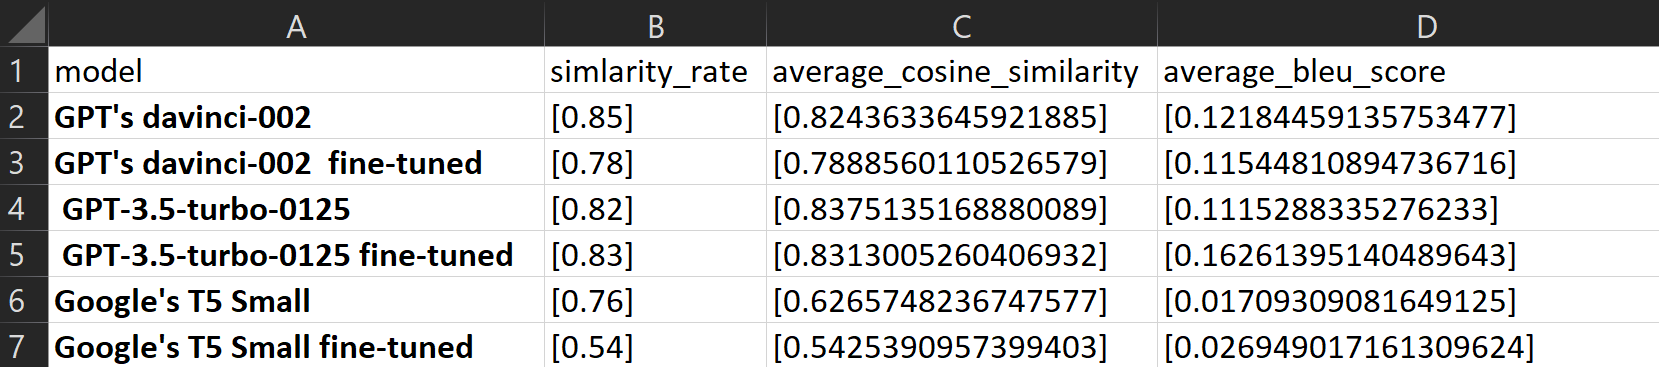
<br>
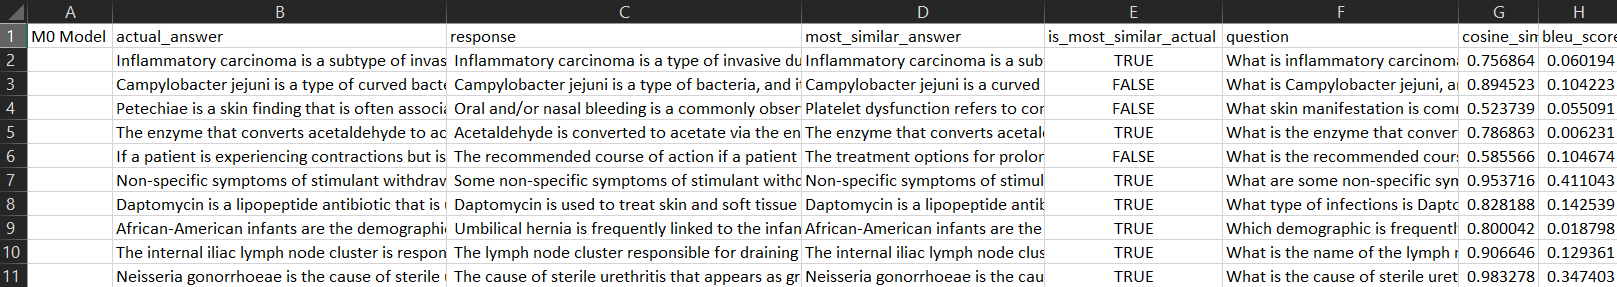
<br>



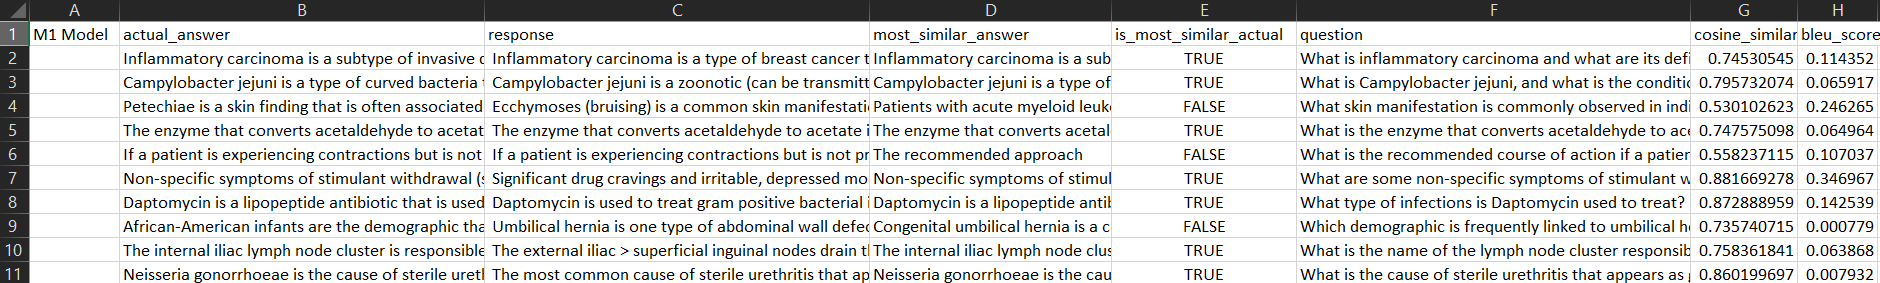
<br>
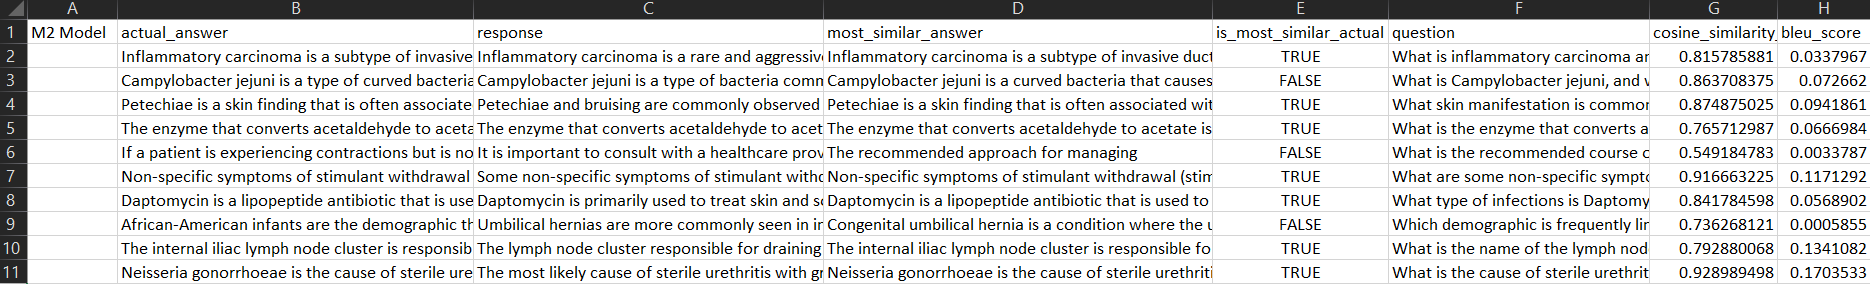
<br>
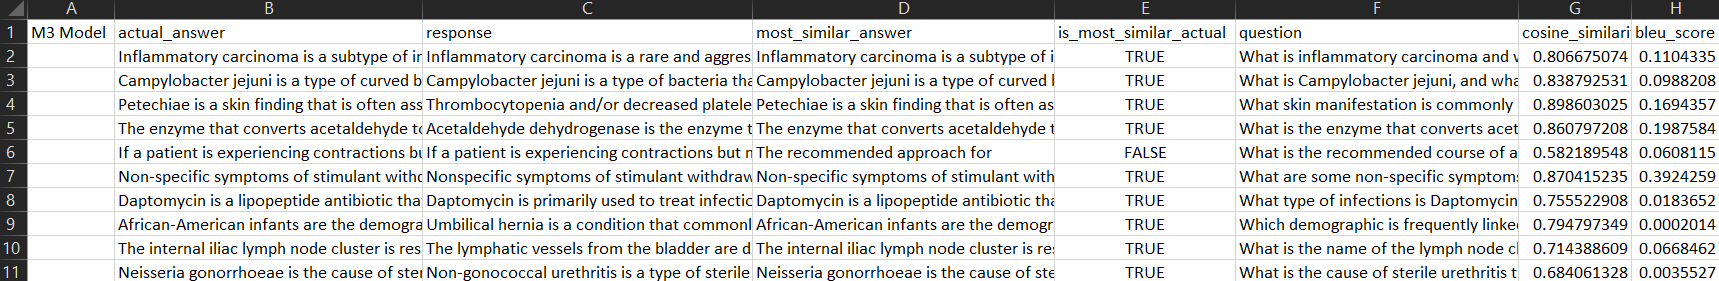